# Exective summary of Work Package 3

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the regression algorithms learnt in the class, in order to achieve best F1 score。

## Tasks

- Task 1: Develop a regression model to predict the reference value for motor temperature.
- Task 2: Develop a fault detection model using the regression model you developed in Task 1.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_3_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Predict normal behaviors through regression models

In this task, let us try to develop a best regression model to predict the normal behaviors of a given motor. In this exercise, we can use motor 6 as an example. You can easilily generate the approach to other models for the data challenge.

We can use all the dataset where motor 6 works normally as our dataset. Then, we can run a cross validation (based on sequence, not points) to test the performances of the developed model.

In this example, we mainly use the following performance metrics:
- max error: The max error between the predicted and the true values.
- Mean root squared error: The mean root squared error between the predicted and the true values.
- Out-of-boundary rate: The percentage that the residual error between the predicted and the true values is larger than a given threshold. Here, we set the thresold to be $3$ degree.

## Sub-task 1: Only use the features at the current moment.

[This notebook](demo_regression_mdl.ipynb) provides a basic demonstration of how to set up the experiment. Let us start by considering only using the features from the current moment. In the notebook, we show a baseline using a simple linear regression with all the features. Could you please try to improve the performance of the model?

A few possible directions:
- Feature selection?
- Smoothing?
- Removing sequence-to-sequence variablity? Adding features regarding time dynamics (see the TD for last lecture).
- Changing to other regression models? For this, you can try different regression models from [here](https://scikit-learn.org/stable/supervised_learning.html)

Put your code below.

In [1]:
# Import the libraries

import sys
sys.path.insert(0, 'C:/Users/gioca/GitHub/projects/maintenance_industry_4_2024/supporting_scripts/WP_2_20240516/')
from utility import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg, read_all_csvs_one_test, run_cv_one_motor, show_reg_result, show_clf_result
import numpy as np
from numpy import where
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor


In [2]:
# Data Reading and Outlier Removal
base_dictionary = 'C:/Users/gioca/GitHub/projects/maintenance_industry_4_2024/dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, is_plot=False)

normal_test_id = ['20240105_164214', '20240105_165300', '20240105_165972', '20240320_152031', '20240320_153841',
                  '20240320_155664', '20240321_122650', '20240325_135213', '20240426_141190', '20240426_141532',
                  '20240426_141602', '20240426_141726', '20240426_141938', '20240426_141980', '20240503_164435']

df_data = df_data[df_data['test_condition'].isin(normal_test_id)]

def removeoutliers (df, experiment, feature):

    model = LocalOutlierFactor(n_neighbors=20)
    df['indice'] = df.reset_index().index
    ds = df.loc[df['test_condition'] == experiment]
    x = pd.DataFrame(ds, columns=['indice',feature])
    model.fit_predict(x)
    lof = model.negative_outlier_factor_ 
    df_out = pd.DataFrame({'indice': x['indice'], 'lof': lof })

    return df_out

features = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage', 
            'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
            'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
            'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
            'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
            'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

for i in range(len(normal_test_id)):
    for j in range(len(features)):
        outliers = removeoutliers(df_data, normal_test_id[i], features[j])
        thresh1 = np.quantile(outliers.lof, 1/3000)
        index = where(outliers.lof<=thresh1)
        final_index = np.ravel(outliers['indice'].iloc[0] + index)
        df_data = df_data[~df_data['indice'].isin(final_index)]

In [3]:
# Definition of the Pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

In [4]:
# Model 1: all features
threshold = 1
df_all_1 = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, feature_list=features, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0  13.123969  4.521851              0.971376
1  12.759905  4.033491              0.990476
2  25.193219  4.232480              0.636437
3   6.871982  3.701900              0.756065
4  10.669683  7.021780              0.874039


Mean performance metric and standard error:
Max error: 13.7238 +- 6.8759
RMSE: 4.7023 +- 1.3305
Exceed boundary rate: 0.8457 +- 0.1495




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [30]:
# Model 2: feature selection based on correlation matrix

X_data = pd.DataFrame(df_data, columns=features)
correlation_matrix = X_data.corr()
# plt.figure(figsize=(10, 10))  # Adjust width and height as needed
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
threshold = 0.3
selected_features_1 = correlation_matrix.columns[correlation_matrix.loc['data_motor_6_temperature'].abs() > threshold].tolist()

threshold = 1
df_sel_1 = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, feature_list=selected_features_1, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   4.817300  2.153193              0.787685
1   8.824116  3.275877              1.000000
2  55.339670  3.625835              0.834912
3   5.707030  3.575665              0.811321
4   7.959355  4.701960              0.855707


Mean performance metric and standard error:
Max error: 16.5295 +- 21.7563
RMSE: 3.4665 +- 0.9117
Exceed boundary rate: 0.8579 +- 0.0834




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [6]:
# Model 3: voltage features excluded

features_no_voltage = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_2_position', 'data_motor_2_temperature',
                       'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_4_position', 'data_motor_4_temperature',
                       'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_6_position', 'data_motor_6_temperature']

threshold = 1
df_no_voltage_1 = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, feature_list=features_no_voltage, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   9.045765  4.386853              0.975700
1  14.139928  4.786639              0.999048
2  18.810248  4.028403              0.750693
3   6.994967  4.473019              0.754717
4   8.126197  4.791908              0.857481


Mean performance metric and standard error:
Max error: 11.4234 +- 4.9518
RMSE: 4.4934 +- 0.3174
Exceed boundary rate: 0.8675 +- 0.1178




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:
# Smoothing Definition

def smoothing(data, experiment, feature, dim):

    ds = data.loc[data['test_condition'] == experiment]
    ds = pd.DataFrame(ds, columns=['time', 'indice', feature])

    ds['aver'] = ds[feature].rolling(dim).mean()

    dict = ds.set_index('indice')['aver'].to_dict()
    for idx, row in data.iterrows():
     if row['indice'] in dict:
        data.at[idx, feature] = dict[row['indice']]

    return data

In [7]:
# Smoothing Execution

df_smoothing = df_data.copy()

for i in range(len(normal_test_id)):
   for j in range(len(features)):
     df_smoothing = smoothing(df_smoothing, normal_test_id[i], features[j], 25)

df_smoothing = df_smoothing.dropna()


In [8]:
# Model 4: all features, data smoothing

threshold = 1
df_all_2 = run_cv_one_motor(motor_idx=6, df_data=df_smoothing, mdl=mdl_linear_regreession, feature_list=features, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0  11.234058  4.052878              0.932780
1   7.431778  4.517819              0.997955
2  22.769134  3.197044              0.824674
3   5.396482  2.830593              0.832836
4  11.373792  7.575421              0.914762


Mean performance metric and standard error:
Max error: 11.6410 +- 6.7228
RMSE: 4.4348 +- 1.8789
Exceed boundary rate: 0.9006 +- 0.0726




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
# Model 5: feature selection based on correlation matrix, data smoothing

X_data = pd.DataFrame(df_smoothing, columns=features)
correlation_matrix = X_data.corr()
# plt.figure(figsize=(10, 10))  # Adjust width and height as needed
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
threshold = 0.3
selected_features_2 = correlation_matrix.columns[correlation_matrix.loc['data_motor_6_temperature'].abs() > threshold].tolist()

threshold = 1
df_sel_2 = run_cv_one_motor(motor_idx=6, df_data=df_smoothing, mdl=mdl_linear_regreession, feature_list=selected_features_2, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   4.908950  1.763334              0.672303
1   7.666419  4.409257              1.000000
2  13.622703  6.991478              0.919618
3   8.346723  5.121828              1.000000
4   8.861857  5.539022              0.861025


Mean performance metric and standard error:
Max error: 8.6813 +- 3.1553
RMSE: 4.7650 +- 1.9249
Exceed boundary rate: 0.8906 +- 0.1354




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
# Model 6: voltage features excluded, data smoothing

features_no_voltage = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_2_position', 'data_motor_2_temperature',
                       'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_4_position', 'data_motor_4_temperature',
                       'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_6_position', 'data_motor_6_temperature']

threshold = 1
df_no_voltage_2 = run_cv_one_motor(motor_idx=6, df_data=df_smoothing, mdl=mdl_linear_regreession, feature_list=features_no_voltage, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   8.550900  4.464727              0.974274
1   8.910532  6.313933              1.000000
2   7.194869  4.036268              0.760834
3   7.248788  4.774894              0.759701
4   7.715723  4.771697              0.854231


Mean performance metric and standard error:
Max error: 7.9242 +- 0.7741
RMSE: 4.8723 +- 0.8607
Exceed boundary rate: 0.8698 +- 0.1141




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
# Data preprocessing (prof function)

from scipy.signal import butter, filtfilt

# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  # Assuming your data is evenly spaced in time

def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 10
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()
    
from utility import read_all_csvs_one_test
import matplotlib.pyplot as plt
import os

# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smooth = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, customized_outlier_removal)
    df_data_smooth = pd.concat([df_data_smooth, tmp_df])
    df_data_smooth = df_data_smooth.reset_index(drop=True)

df_data_smooth = df_data_smooth[df_data_smooth['test_condition'].isin(normal_test_id)]

In [12]:
# Model 7: all features, data smoothing (prof function)

threshold = 1
df_all_3 = run_cv_one_motor(motor_idx=6, df_data=df_data_smooth, mdl=mdl_linear_regreession, feature_list=features, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0  13.750723  2.979289              0.856284
1  10.427738  5.119518              0.983005
2   6.817184  3.274084              0.813810
3   9.096755  3.665289              0.701493
4  14.917425  6.741679              0.911580


Mean performance metric and standard error:
Max error: 11.0020 +- 3.3301
RMSE: 4.3560 +- 1.5666
Exceed boundary rate: 0.8532 +- 0.1059




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
# Model 8: feature selection with correlation matrix, data smoothing (prof function)

X_data = pd.DataFrame(df_data_smooth, columns=features)
correlation_matrix = X_data.corr()
# plt.figure(figsize=(10, 10))  # Adjust width and height as needed
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
threshold = 0.3
selected_features_3 = correlation_matrix.columns[correlation_matrix.loc['data_motor_6_temperature'].abs() > threshold].tolist()

threshold = 1
df_sel_3 = run_cv_one_motor(motor_idx=6, df_data=df_data_smooth, mdl=mdl_linear_regreession, feature_list=selected_features_3, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   5.078343  1.756726              0.679849
1   8.008656  4.493430              1.000000
2  10.876959  5.201895              0.909195
3  10.270740  5.283827              0.980100
4  10.153278  5.515416              0.886480


Mean performance metric and standard error:
Max error: 8.8776 +- 2.3851
RMSE: 4.4503 +- 1.5533
Exceed boundary rate: 0.8911 +- 0.1272




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
# Model 9: voltage features excluded, data smoothing (prof function)

features_no_voltage = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_2_position', 'data_motor_2_temperature',
                       'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_4_position', 'data_motor_4_temperature',
                       'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_6_position', 'data_motor_6_temperature']

threshold = 1
df_no_voltage_3 = run_cv_one_motor(motor_idx=6, df_data=df_data_smooth, mdl=mdl_linear_regreession, feature_list=features_no_voltage, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   8.421144  4.166940              0.976149
1   9.366627  6.378738              1.000000
2   6.993277  3.917188              0.775907
3   7.188595  4.570516              0.753731
4   8.316629  4.795391              0.822019


Mean performance metric and standard error:
Max error: 8.0573 +- 0.9748
RMSE: 4.7658 +- 0.9643
Exceed boundary rate: 0.8656 +- 0.1148




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [6]:
# Sequence-To-Sequence Variability

def compensate_seq_bias(df: pd.DataFrame):
    ''' # Description
    Adjust for the sequence-to-sequence bias.
    '''
    # Tranform the features relative to the first data point.
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
    df['position'] = df['position'] - df['position'].iloc[0]

def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()        

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()        

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - Adjust for the sequence-to-sequence bias.
    - add new features about the difference between the current and previous n data point.
    '''     
    # Start processing.
    remove_outliers(df)
    compensate_seq_bias(df)

df_data_sts = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)
df_data_sts['indice'] = df_data_sts.reset_index().index

tests = ['20240105_164214', '20240105_165300', '20240105_165972', '20240320_152031', '20240320_153841',
         '20240320_155664', '20240321_122650', '20240325_135213', '20240325_155003', '20240425_093699', 
         '20240425_094425', '20240426_140055', '20240426_141190', '20240426_141532', '20240426_141602',
         '20240426_141726', '20240426_141938', '20240426_141980', '20240503_163963', '20240503_164435',
         '20240503_164675', '20240503_165189']

for i in range(len(tests)):
   for j in range(len(features)):
     df_data_sts = smoothing(df_data_sts, tests[i], features[j], 25)

df_data_sts = df_data_sts.dropna()
df_data_sts_tr = df_data_sts[df_data_sts['test_condition'].isin(normal_test_id)]

In [ ]:
# Model 10: all features, sequence-to-sequence variability

threshold = 1
df_all_smooth_4 = run_cv_one_motor(motor_idx=6, df_data=df_data_sts_tr, mdl=mdl_linear_regreession, feature_list=features, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0  12.700275  5.339700              0.962830
1  11.121603  2.158902              0.499044
2  11.451561  5.508573              0.829119
3  11.406325  4.560663              0.857923
4  14.814753  9.382691              0.897085


Mean performance metric and standard error:
Max error: 12.2989 +- 1.5323
RMSE: 5.3901 +- 2.6022
Exceed boundary rate: 0.8092 +- 0.1805




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Model 11: feature selection with correlation matrix, sequence-to-sequence variability

X_data = pd.DataFrame(df_data_sts_tr, columns=features)
correlation_matrix = X_data.corr()
plt.figure(figsize=(10, 10))  # Adjust width and height as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
threshold = 0.25
selected_features_4 = correlation_matrix.columns[correlation_matrix.loc['data_motor_6_temperature'].abs() > threshold].tolist()

threshold = 1
df_sel_4 = run_cv_one_motor(motor_idx=6, df_data=df_data_sts_tr, mdl=mdl_linear_regreession, feature_list=selected_features_4, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

NameError: name 'df_data_sts_tr' is not defined

In [ ]:
# Model 12: voltage features excluded, sequence-to-sequence variability

features_no_voltage = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_2_position', 'data_motor_2_temperature',
                       'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_4_position', 'data_motor_4_temperature',
                       'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_6_position', 'data_motor_6_temperature']

threshold = 1
df_no_voltage_4 = run_cv_one_motor(motor_idx=6, df_data=df_data_sts_tr, mdl=mdl_linear_regreession, feature_list=features_no_voltage, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0  12.383555  3.574975              0.929972
1   4.378222  1.968402              0.410134
2  11.505006  5.834052              0.859601
3   6.408303  2.665664              0.531421
4  13.818204  7.554588              0.982748


Mean performance metric and standard error:
Max error: 9.6987 +- 4.0797
RMSE: 4.3195 +- 2.3225
Exceed boundary rate: 0.7428 +- 0.2557




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Summary of the results - Only using features from the current moment**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| 1. All Features |   13,70 +- 6,83  |   4,70 +- 1,33   |  0,85 +- 0,15 | 
| 2. Selected Features |   16,53 +- 21,76  |   3,47 +- 0,91   |  0,86 +- 0,08 | 
| 3. No Voltage Features |   11,42 +- 4,95  |   4,49 +- 0,32   |  0,87 +- 0,12 | 
| 4. All Features, Smoothing (1) |   11,64 +- 6,72  |   4,43 +- 1,88   |  0,90 +- 0,07 | 
| 5. Selected Features, Smoothing (1) |   8,68 +- 3,16  |   4,77 +- 1,92   |  0,89 +- 0,14 | 
| 6. No Voltage Features, Smoothing (1) |   7,92 +- 0,77  |   4,87 +- 0,86   |  0,87 +- 0,11 | 
| 7. All Features, Smoothing (2) |   11,00 +- 3,33  |   4,36 +- 1,57   |  0,85 +- 0,11 | 
| 8. Selected Features, Smoothing (2) |   8,88 +- 2,39  |   4,45 +- 1,55   |  0,89 +- 0,13 | 
| 9. No Voltage Features, Smoothing (2) |   8,06 +- 0,97  |   4,77 +- 0,96   |  0,87 +- 0,11 | 
| 10. All Features, Smoothing (1), STS Variability |   12,30 +- 1,53  |   5,39 +- 2,60   |  0,81 +- 0,18 | 
| 11. Selected Features, Smoothing (1), STS Variability |   7,64 +- 2,33  |   2,42 +- 1,50   |  0,52 +- 0,32 | 
| 12. No Voltage Features, Smoothing (1), STS Variability |   9,70 +- 4,08  |   4,32 +- 2,32   |  0,74 +- 0,26 | 

## Sub-task 2: Include the features in the past

Now, let's consider using the sliding window approach to include the past in the regression model as well. Please have a look at the demo notebook, run your experiment, and report the best models you could have if you apply the sliding window approach.

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 0.07734683852935031
training performance, mean root square error is: 0.006669760596333654
training performance, residual error > 1: 0.0%

 New run:

testing performance, max error is: 0.0776521454757052
testing performance, mean root square error is: 0.009399947955506941
testing performance, residual error > 1: 0.0%


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


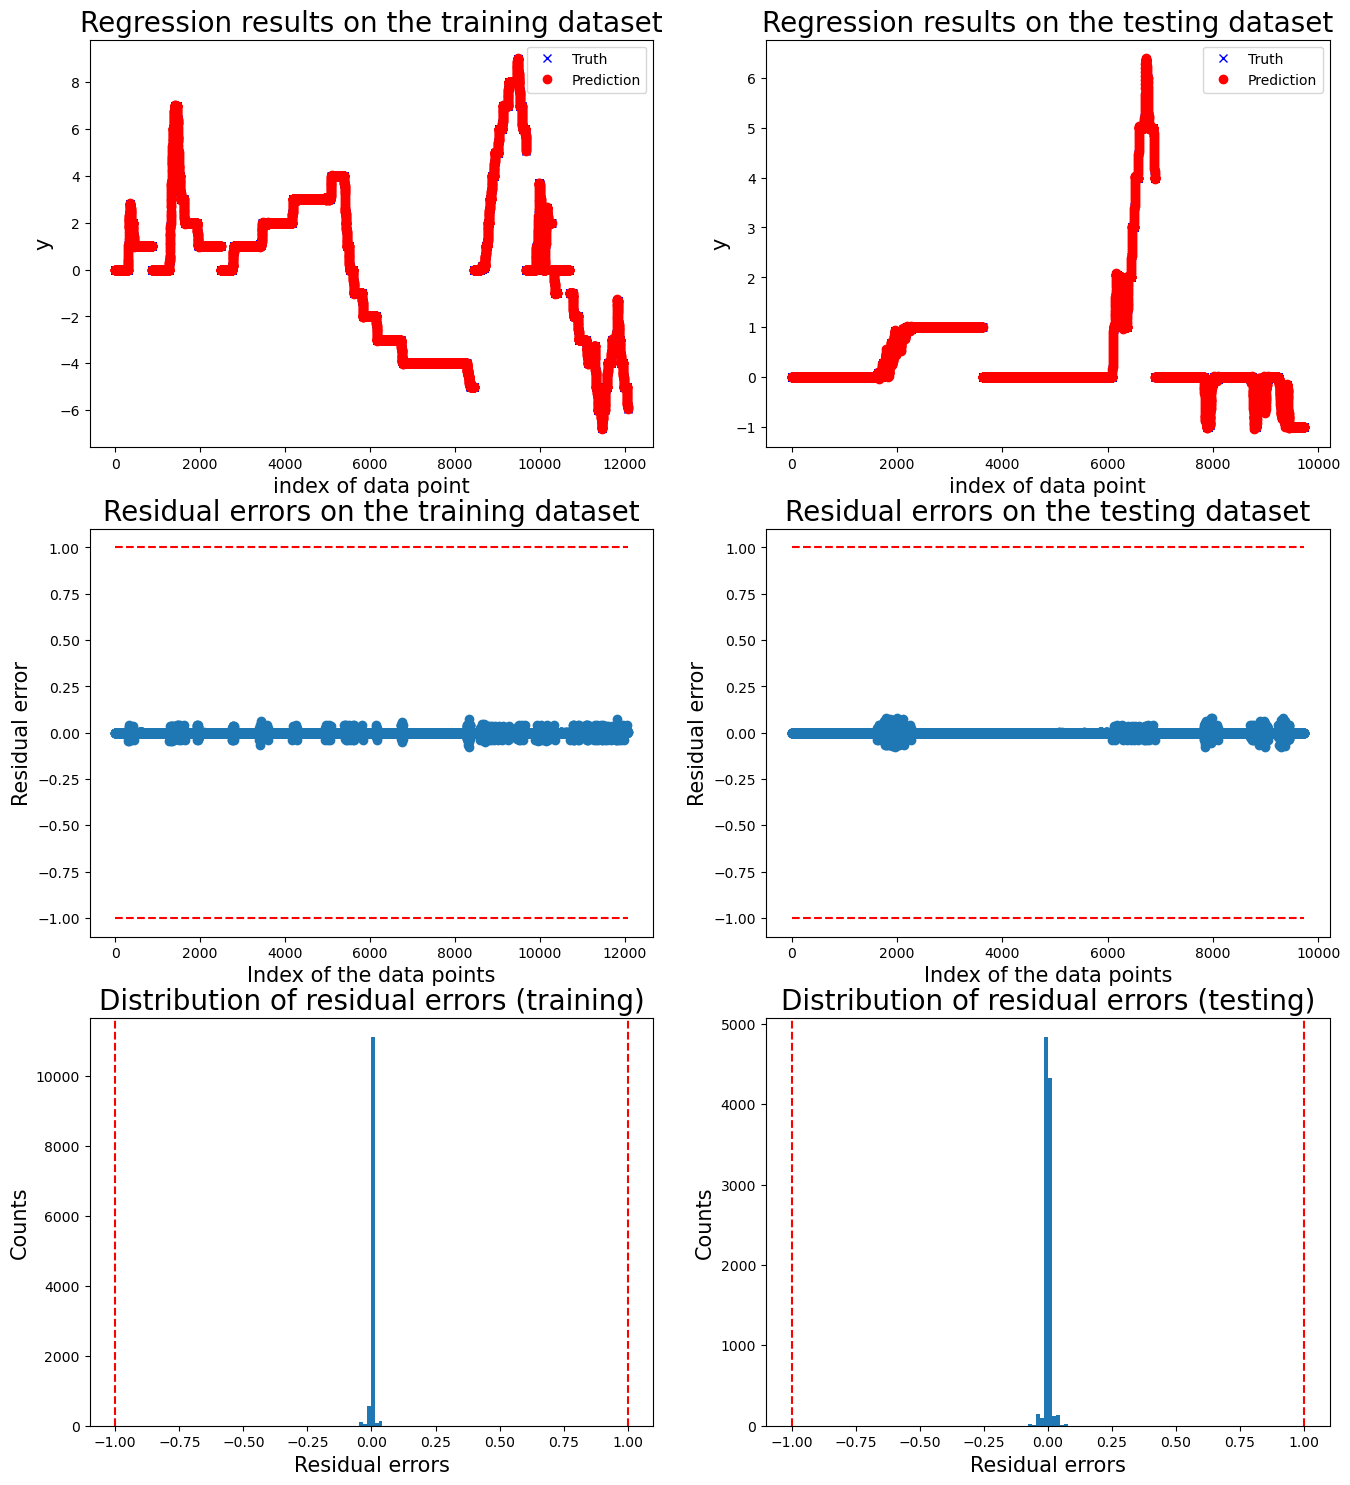

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 0.07581121751809372
training performance, mean root square error is: 0.00797346740754599
training performance, residual error > 1: 0.0%

 New run:

testing performance, max error is: 0.04701977499073595
testing performance, mean root square error is: 0.005155204663446075
testing performance, residual error > 1: 0.0%


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


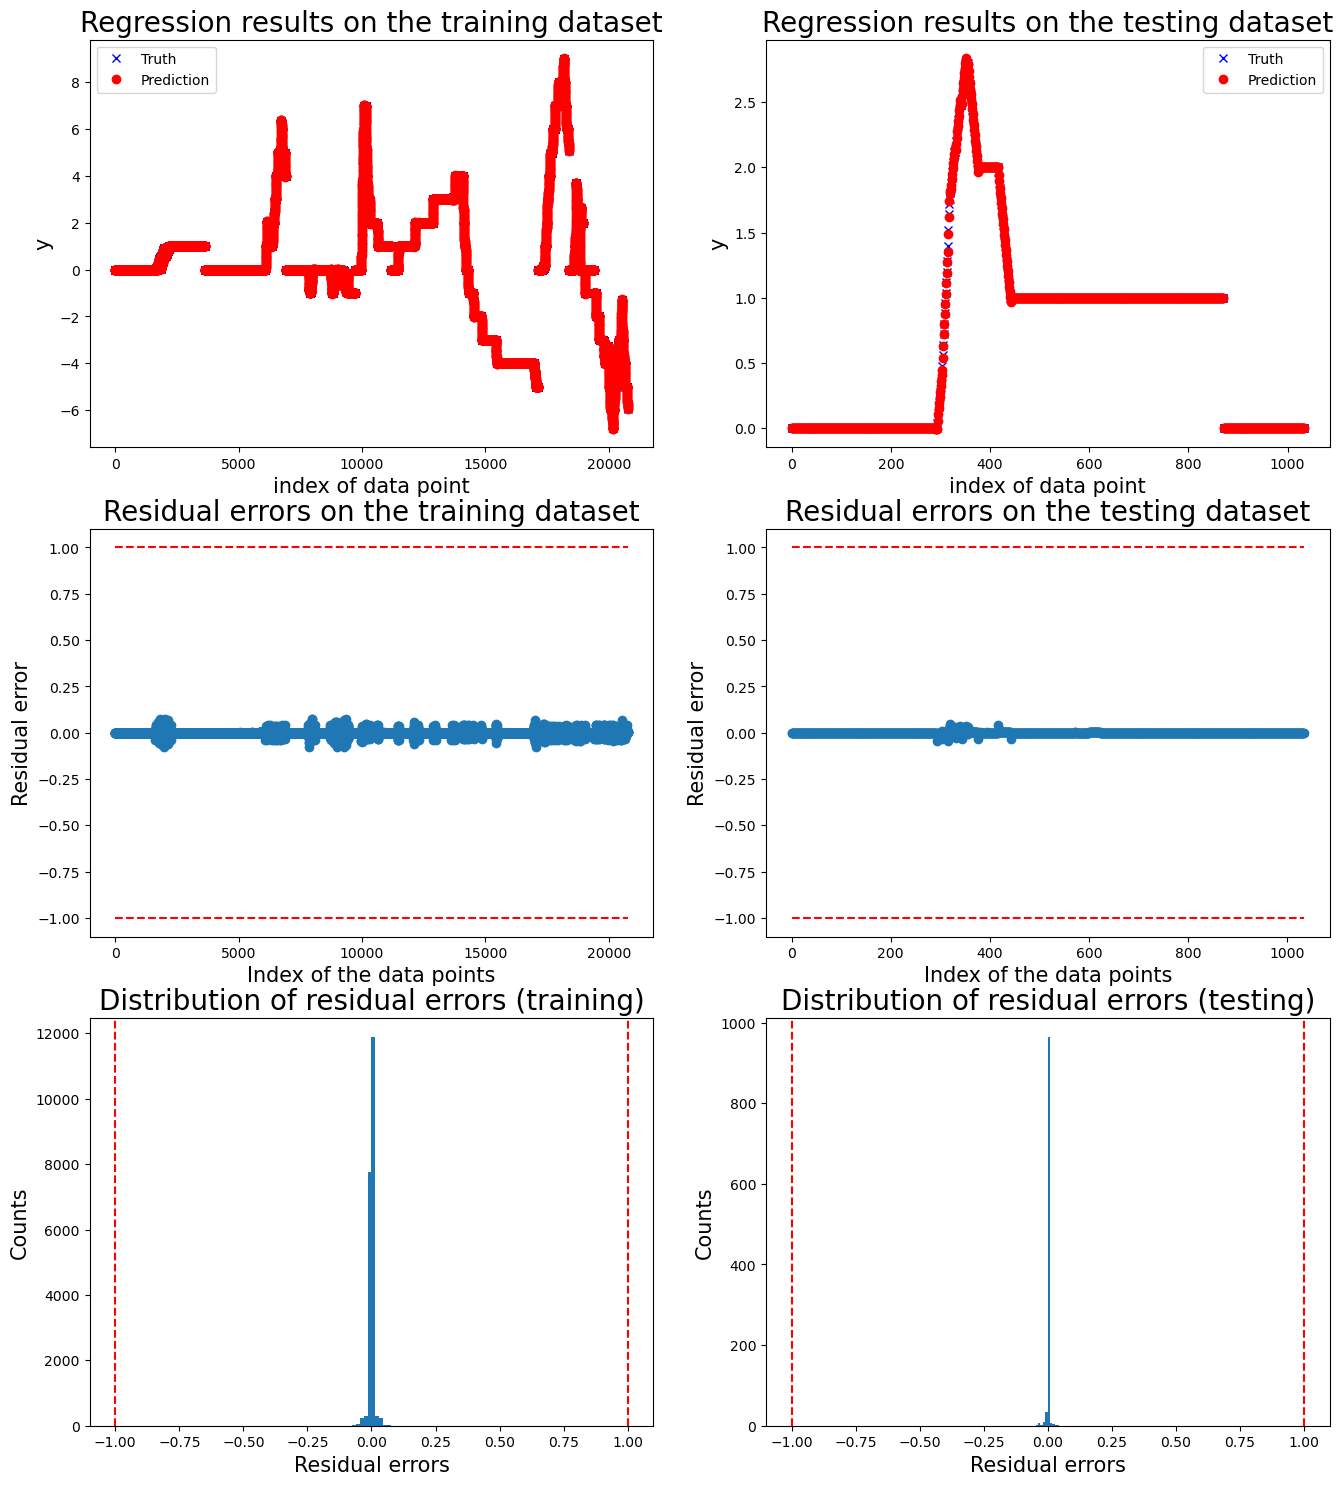

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 0.07470307769948992
training performance, mean root square error is: 0.008582024228791433
training performance, residual error > 1: 0.0%

 New run:

testing performance, max error is: 0.07474059781755571
testing performance, mean root square error is: 0.006657439432526774
testing performance, residual error > 1: 0.0%


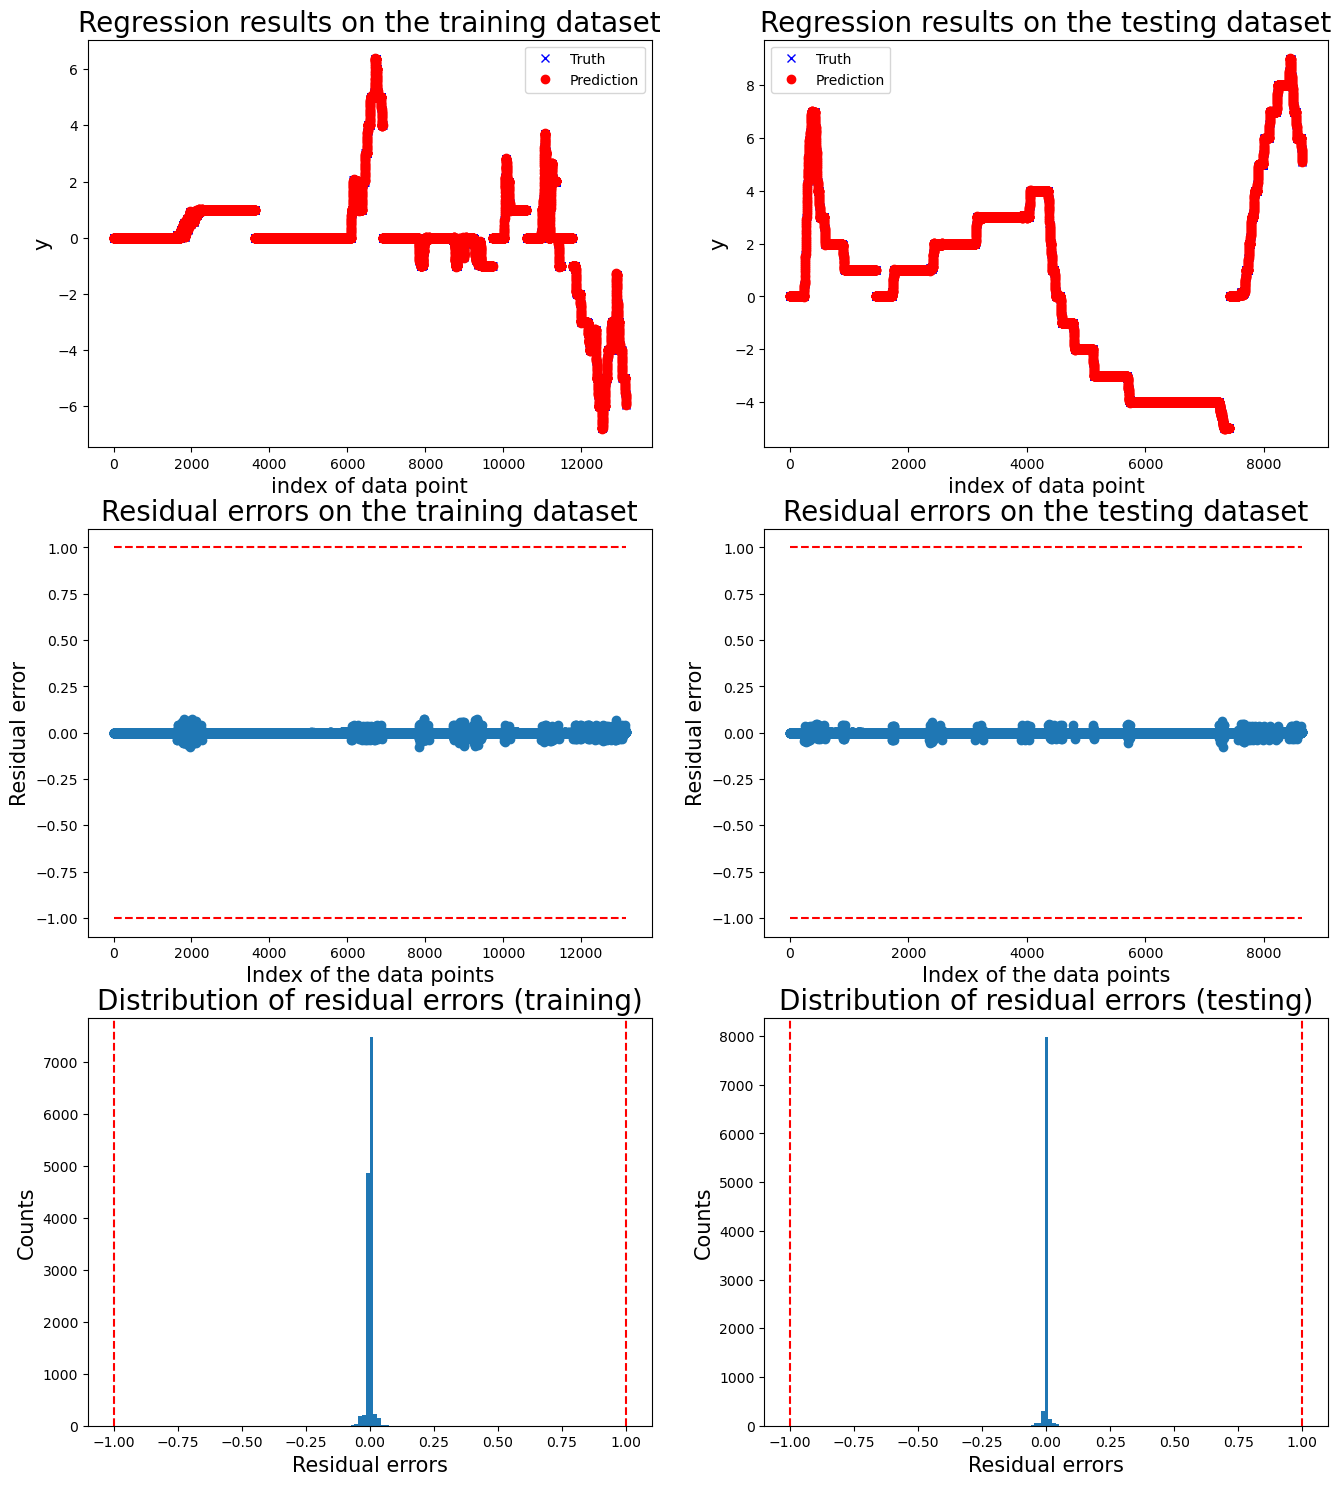

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 0.07556751175190446
training performance, mean root square error is: 0.007852063674636403
training performance, residual error > 1: 0.0%

 New run:

testing performance, max error is: 0.04799051335807558
testing performance, mean root square error is: 0.008202064484588562
testing performance, residual error > 1: 0.0%


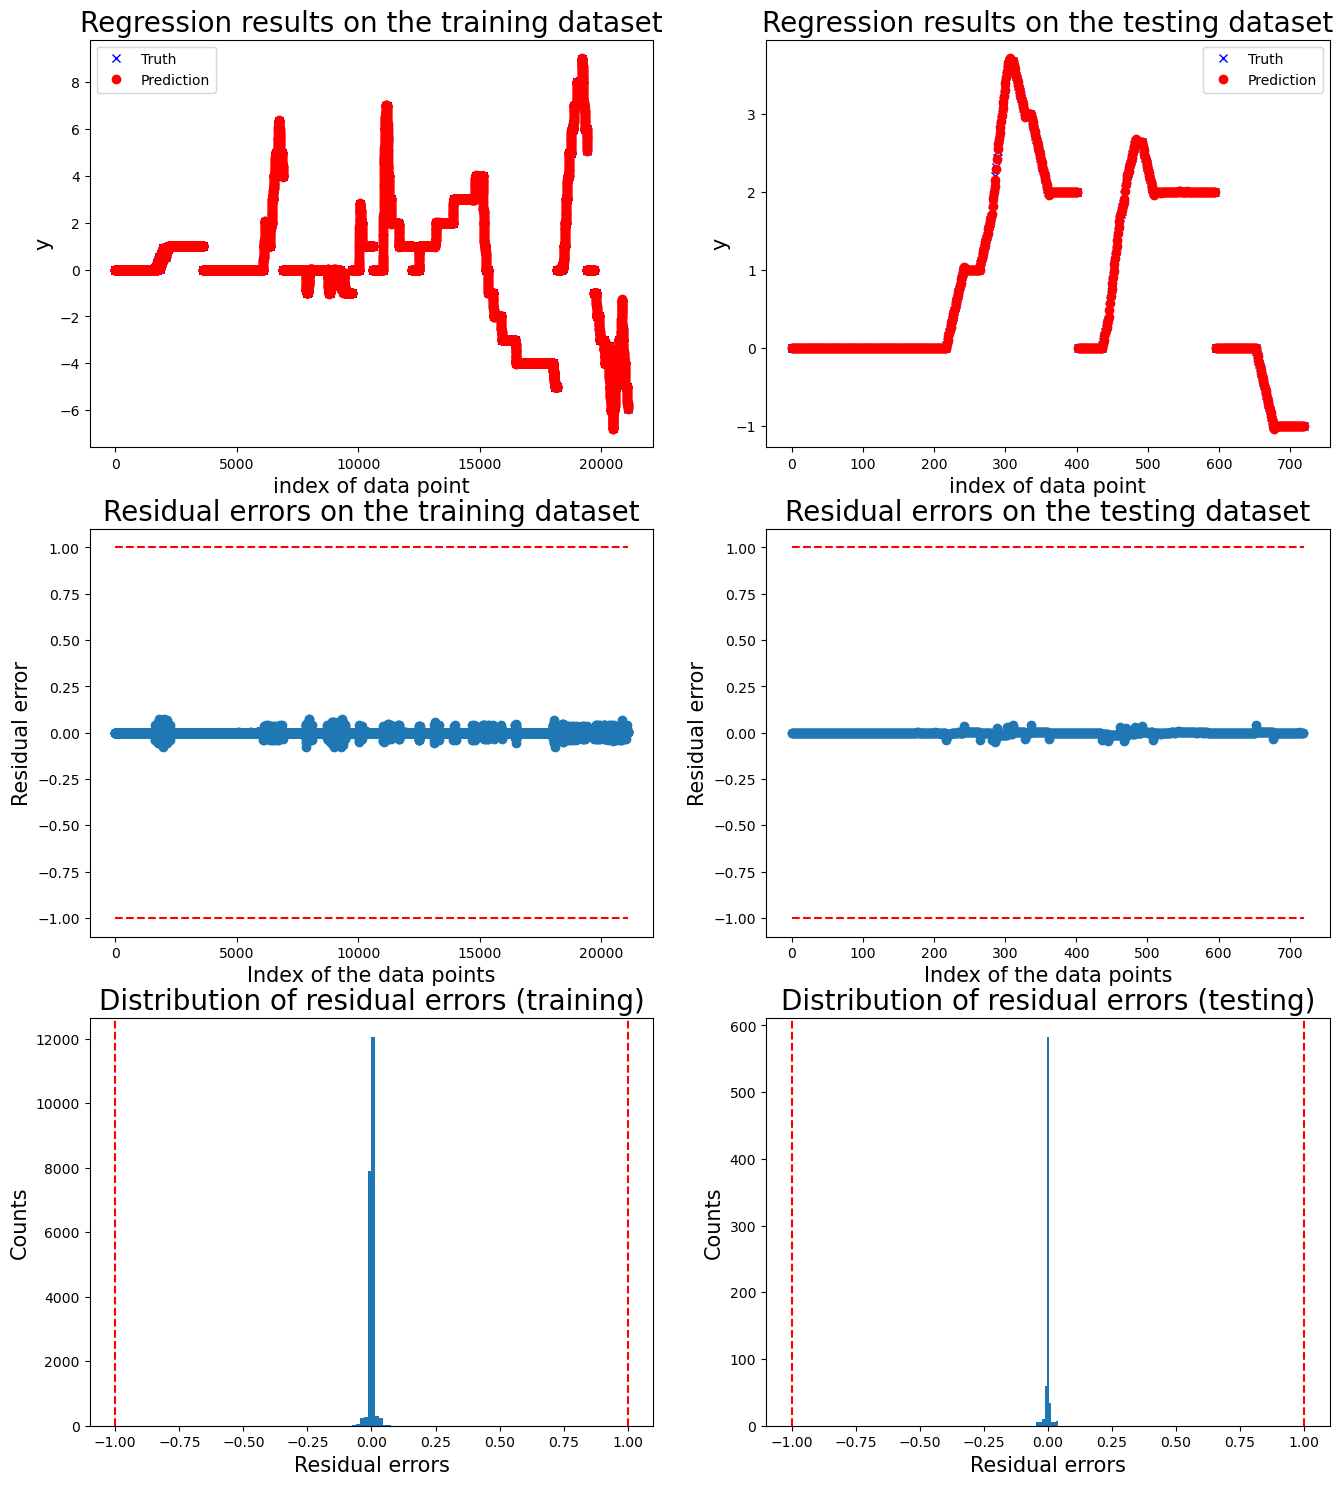

c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 0.07553407686972069
training performance, mean root square error is: 0.007825915947488155
training performance, residual error > 1: 0.0%

 New run:

testing performance, max error is: 0.0685560147440325
testing performance, mean root square error is: 0.008370873868794319
testing performance, residual error > 1: 0.0%


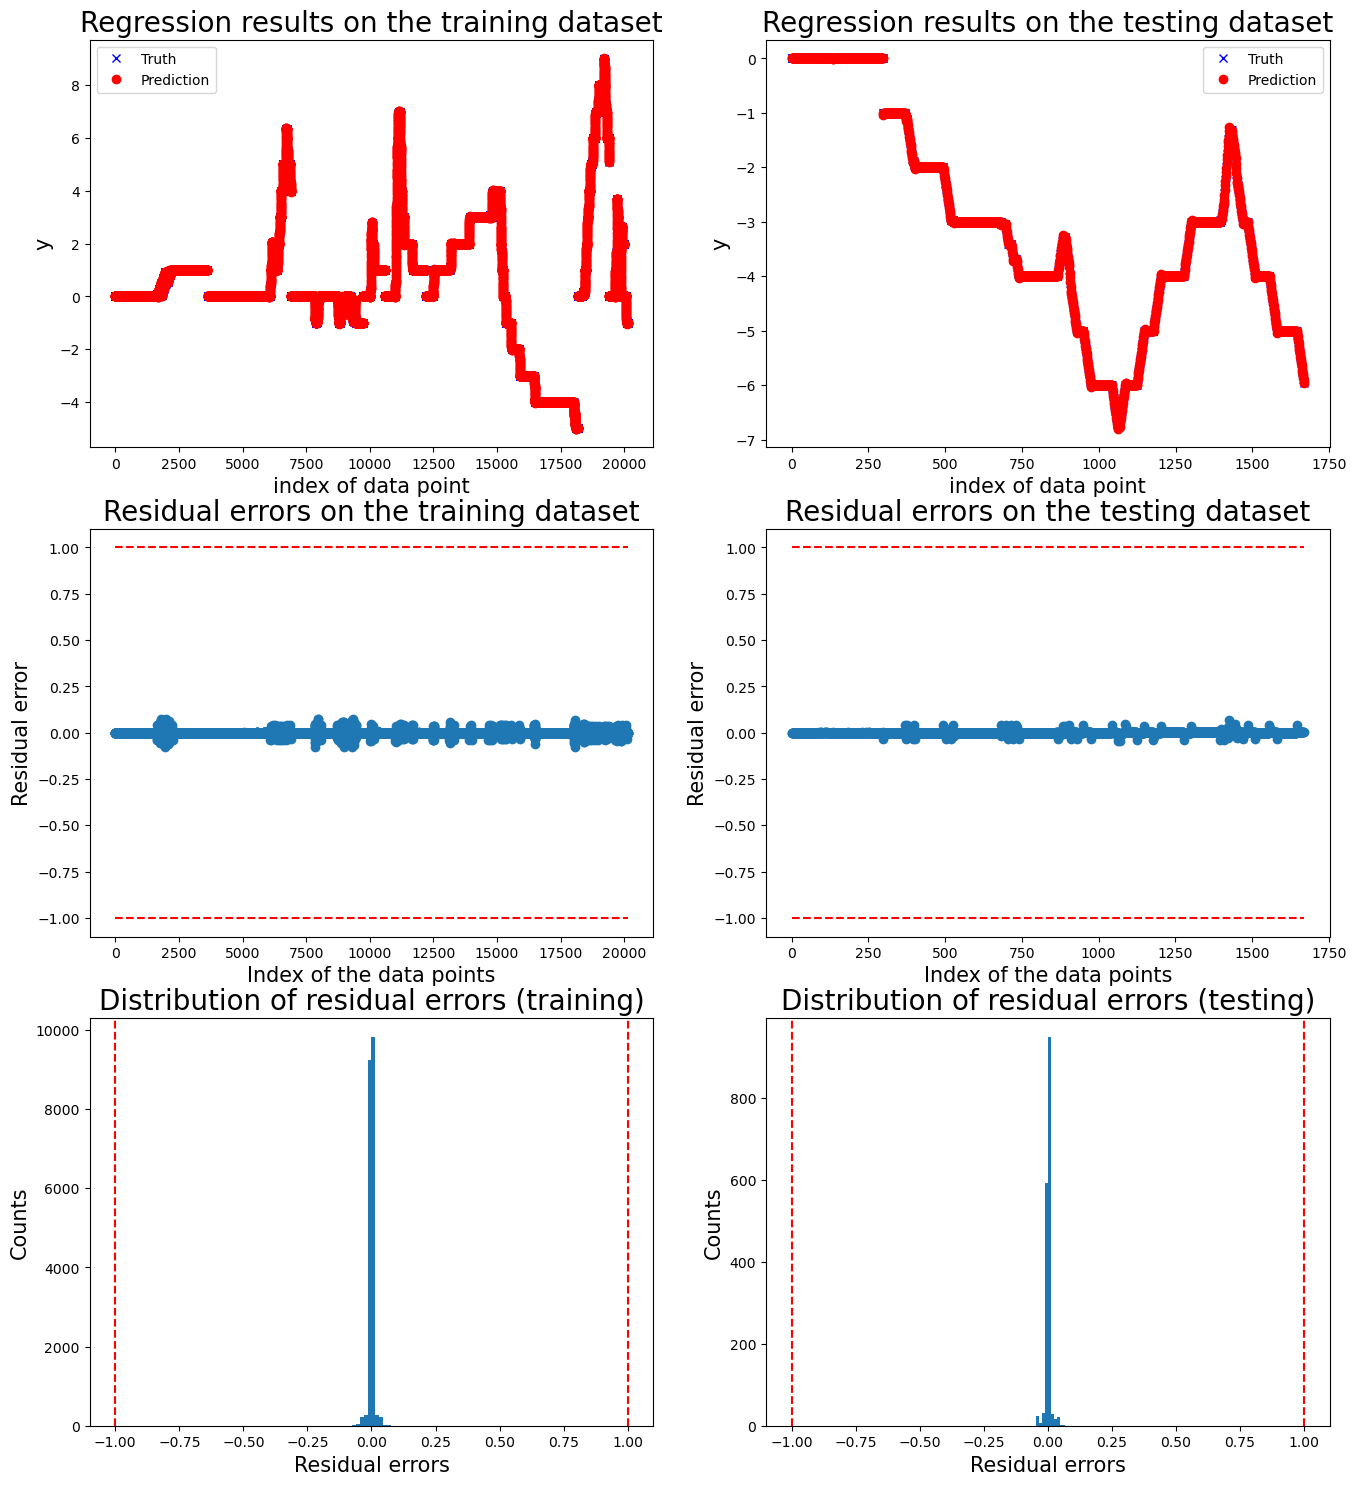

   Max error      RMSE  Exceed boundary rate
0   0.077652  0.009400                   0.0
1   0.047020  0.005155                   0.0
2   0.074741  0.006657                   0.0
3   0.047991  0.008202                   0.0
4   0.068556  0.008371                   0.0


Mean performance metric and standard error:
Max error: 0.0632 +- 0.0147
RMSE: 0.0076 +- 0.0017
Exceed boundary rate: 0.0000 +- 0.0000




In [8]:
# Model 11, window = 5, sample = 1

threshold = 1
window_size = 5
sample_step = 1
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

df_sel_4_window_1 = run_cv_one_motor(motor_idx=6, df_data=df_data_sts_tr, mdl=mdl_linear_regreession, feature_list=selected_features_4, 
                            window_size=window_size, sample_step=sample_step, n_fold=5, threshold=threshold, mdl_type='reg')

In [9]:
# Model 11, window = 50, sample = 10

threshold = 1
window_size = 50
sample_step = 10
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

df_sel_4_window_2 = run_cv_one_motor(motor_idx=6, df_data=df_data_sts_tr, mdl=mdl_linear_regreession, feature_list=selected_features_4, 
                            window_size=window_size, sample_step=sample_step, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   0.491352  0.061845                   0.0
1   0.396818  0.079782                   0.0
2   0.586539  0.079052                   0.0
3   0.482651  0.152369                   0.0
4   0.618052  0.134444                   0.0


Mean performance metric and standard error:
Max error: 0.5151 +- 0.0885
RMSE: 0.1015 +- 0.0394
Exceed boundary rate: 0.0000 +- 0.0000




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [21]:
# Model 2, window = 5, sample = 1

threshold = 1
window_size = 5
sample_step = 1
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

df_sel_1_window_1 = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, feature_list=selected_features_1, 
                            window_size=window_size, sample_step=sample_step, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   1.018586  0.165502              0.004639
1   1.002757  0.095527              0.000963
2   1.179037  0.122841              0.003008
3   1.026351  0.146347              0.002740
4   1.021543  0.148666              0.005360


Mean performance metric and standard error:
Max error: 1.0497 +- 0.0729
RMSE: 0.1358 +- 0.0272
Exceed boundary rate: 0.0033 +- 0.0017




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
# Model 1, window = 5, sample = 1

threshold = 1
window_size = 5
sample_step = 1
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

df_all_1_window_1 = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, feature_list=features, 
                            window_size=window_size, sample_step=sample_step, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   1.038431  0.165787              0.004433
1   1.045970  0.093914              0.002890
2   1.086477  0.123664              0.002198
3   1.033289  0.144928              0.004110
4   1.337769  0.153866              0.003574


Mean performance metric and standard error:
Max error: 1.1084 +- 0.1299
RMSE: 0.1364 +- 0.0283
Exceed boundary rate: 0.0034 +- 0.0009




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
# Model 11, window = 5, sample = 3

threshold = 1
window_size = 5
sample_step = 3
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

df_sel_4_window_3 = run_cv_one_motor(motor_idx=6, df_data=df_data_sts_tr, mdl=mdl_linear_regreession, feature_list=selected_features_4, 
                            window_size=window_size, sample_step=sample_step, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   0.195311  0.028188                   0.0
1   0.294448  0.041021                   0.0
2   0.261043  0.042239                   0.0
3   0.279116  0.077031                   0.0
4   0.238772  0.060632                   0.0


Mean performance metric and standard error:
Max error: 0.2537 +- 0.0387
RMSE: 0.0498 +- 0.0191
Exceed boundary rate: 0.0000 +- 0.0000




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
# Model 11, window = 3, sample = 1

threshold = 1
window_size = 3
sample_step = 1
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

df_sel_4_window_4 = run_cv_one_motor(motor_idx=6, df_data=df_data_sts_tr, mdl=mdl_linear_regreession, feature_list=selected_features_4, 
                            window_size=window_size, sample_step=sample_step, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   0.076327  0.010412                   0.0
1   0.055140  0.005120                   0.0
2   0.070668  0.007381                   0.0
3   0.053758  0.008429                   0.0
4   0.062175  0.008198                   0.0


Mean performance metric and standard error:
Max error: 0.0636 +- 0.0098
RMSE: 0.0079 +- 0.0019
Exceed boundary rate: 0.0000 +- 0.0000




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [42]:
# Model 11, window = 10, sample = 1

threshold = 1
window_size = 10
sample_step = 1
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

df_sel_4_window_4 = run_cv_one_motor(motor_idx=6, df_data=df_data_sts_tr, mdl=mdl_linear_regreession, feature_list=selected_features_4, 
                            window_size=window_size, sample_step=sample_step, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   0.078025  0.009361                   0.0
1   0.047370  0.005366                   0.0
2   0.072146  0.006656                   0.0
3   0.051320  0.008634                   0.0
4   0.065704  0.008665                   0.0


Mean performance metric and standard error:
Max error: 0.0629 +- 0.0132
RMSE: 0.0077 +- 0.0017
Exceed boundary rate: 0.0000 +- 0.0000




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:
# Model 11, window = 5, sample = 1

threshold = 1
window_size = 5
sample_step = 1
prediction_lead_time = 3 # We add the temperature measurement up to 1 point before the current time.

df_sel_4_window_5 = run_cv_one_motor(motor_idx=6, df_data=df_data_sts_tr, mdl=mdl_linear_regreession, feature_list=selected_features_4, 
                            window_size=window_size, sample_step=sample_step, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   0.077652  0.009400                   0.0
1   0.047020  0.005155                   0.0
2   0.074741  0.006657                   0.0
3   0.047991  0.008202                   0.0
4   0.068556  0.008371                   0.0


Mean performance metric and standard error:
Max error: 0.0632 +- 0.0147
RMSE: 0.0076 +- 0.0017
Exceed boundary rate: 0.0000 +- 0.0000




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
# Model 11, window = 10, sample = 1

threshold = 1
window_size = 10
sample_step = 1
prediction_lead_time = 3 # We add the temperature measurement up to 1 point before the current time.

df_sel_4_window_6 = run_cv_one_motor(motor_idx=6, df_data=df_data_sts_tr, mdl=mdl_linear_regreession, feature_list=selected_features_4, 
                            window_size=window_size, sample_step=sample_step, n_fold=5, threshold=threshold, mdl_type='reg', single_run_result=False)

Model for motor 6:


c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared

   Max error      RMSE  Exceed boundary rate
0   0.078025  0.009361                   0.0
1   0.047370  0.005366                   0.0
2   0.072146  0.006656                   0.0
3   0.051320  0.008634                   0.0
4   0.065704  0.008665                   0.0


Mean performance metric and standard error:
Max error: 0.0629 +- 0.0132
RMSE: 0.0077 +- 0.0017
Exceed boundary rate: 0.0000 +- 0.0000




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Summary of the results - Sliding window**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model | Window size | Sample step | Prediction LT | Max error | MRSE | Exceed boundary rate |
|----------|----------|-------------|---------------|--------------------|--------------------|-------|
| Model 11 |    5     |      1      |       1       |    0,063 +- 0,015  |   0,008 +- 0,002   |  0,00 | 
| Model 11 |    50    |     10      |       1       |    0,510 +- 0,079  |   0,103 +- 0,040   |  0,00 | 
| Model 2  |    5     |      1      |       1       |    1,050 +- 0,073  |   0,136 +- 0,027   |  0,00 | 
| Model 1  |    5     |      1      |       1       |    1,108 +- 0,130  |   0,136 +- 0,028   |  0,00 | 
| Model 11 |    5     |      3      |       1       |    0,254 +- 0,039  |   0,050 +- 0,019   |  0,00 | 
| Model 11 |    3     |      1      |       1       |    0,064 +- 0,010  |   0,008 +- 0,002   |  0,00 | 
| Model 11 |    10    |      1      |       1       |    0,063 +- 0,013  |   0,008 +- 0,002   |  0,00 | 
| Model 11 |    5     |      1      |       3       |    0,063 +- 0,015  |   0,008 +- 0,002   |  0,00 | 
| Model 11 |    10    |      1      |       3       |    0,063 +- 0,015  |   0,008 +- 0,002   |  0,00 | 

# Task 2 Fault detection based on regression model

In this exercise, we use the dataset that contains the failure of motor 6 to test the fault detection model based on the regression model trained before. 

[This notebook](demo_FaultDetectReg.ipynb) presents a demonstration of how to use the provided supporting function to develop fault detection model based on the regression model. Please have a look at this notebook, and try to improve the performance of the baseline model.

  0%|          | 0/7 [00:00<?, ?it/s]c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWa

Model for motor 6:


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\gioca\GitHub\.conda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWa


 New run:

testing performance, max error is: 1.032092128667022
testing performance, mean root square error is: 0.1708048644498349
testing performance, residual error > 1.0804581469036347: 0.0%

 New run:

testing performance, accuracy is: 0.9008014516860728
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


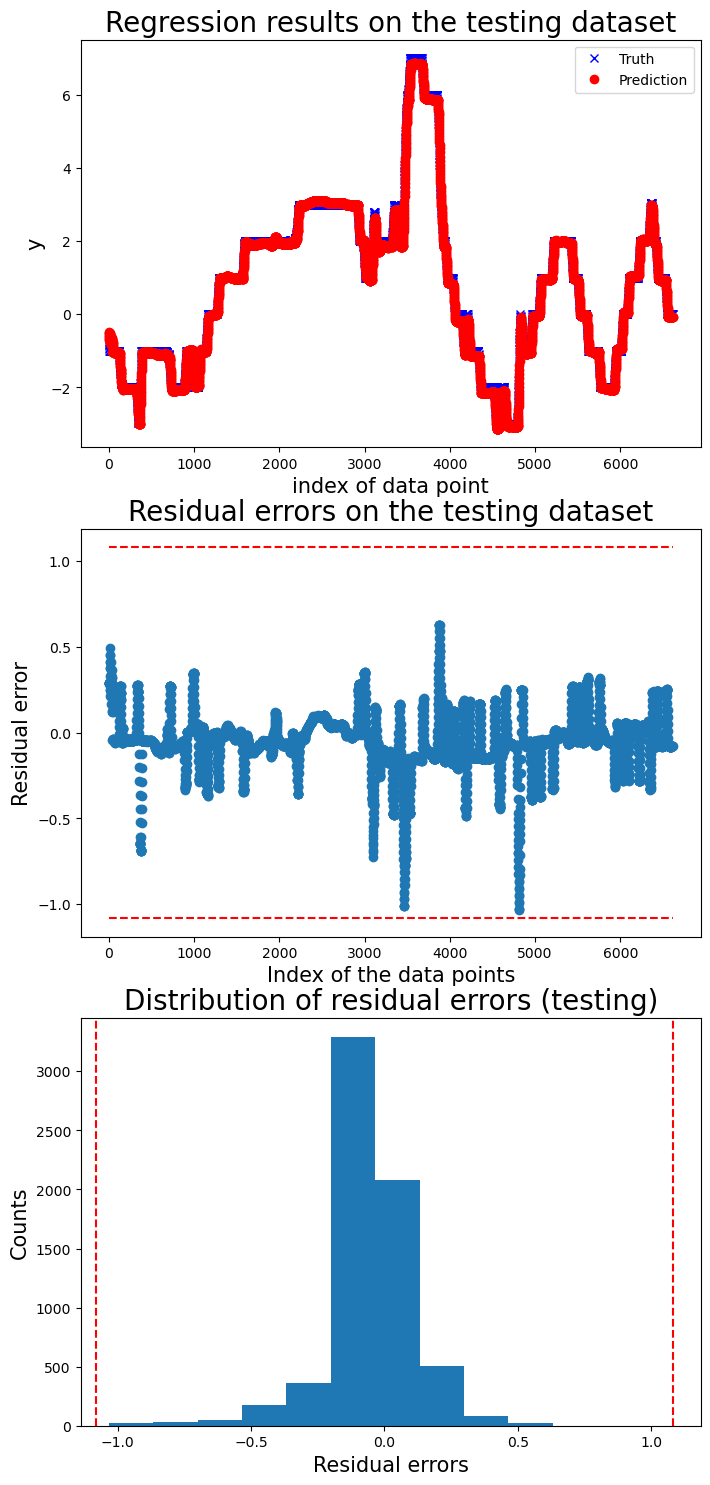

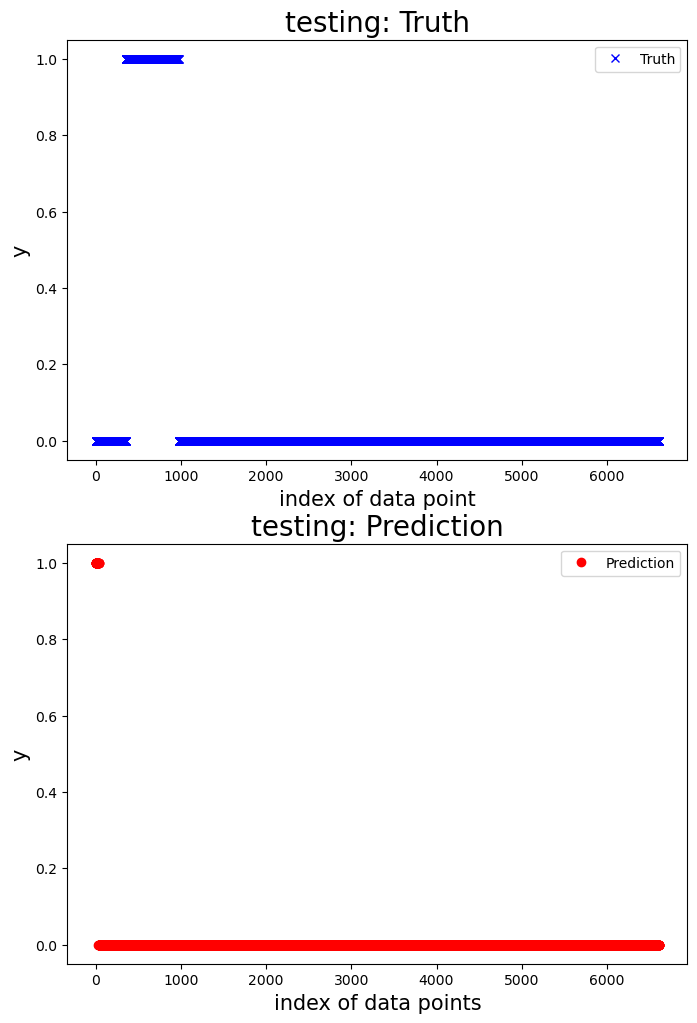

100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



 New run:

testing performance, max error is: 5.780584082216907
testing performance, mean root square error is: 1.8336140766728999
testing performance, residual error > 0.15: 51.041666666666664%

 New run:

testing performance, accuracy is: 0.8645833333333334
testing performance, precision is: 0.7857142857142857
testing performance, recall: 0.9390243902439024
testing performance, F1: 0.8555555555555555




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


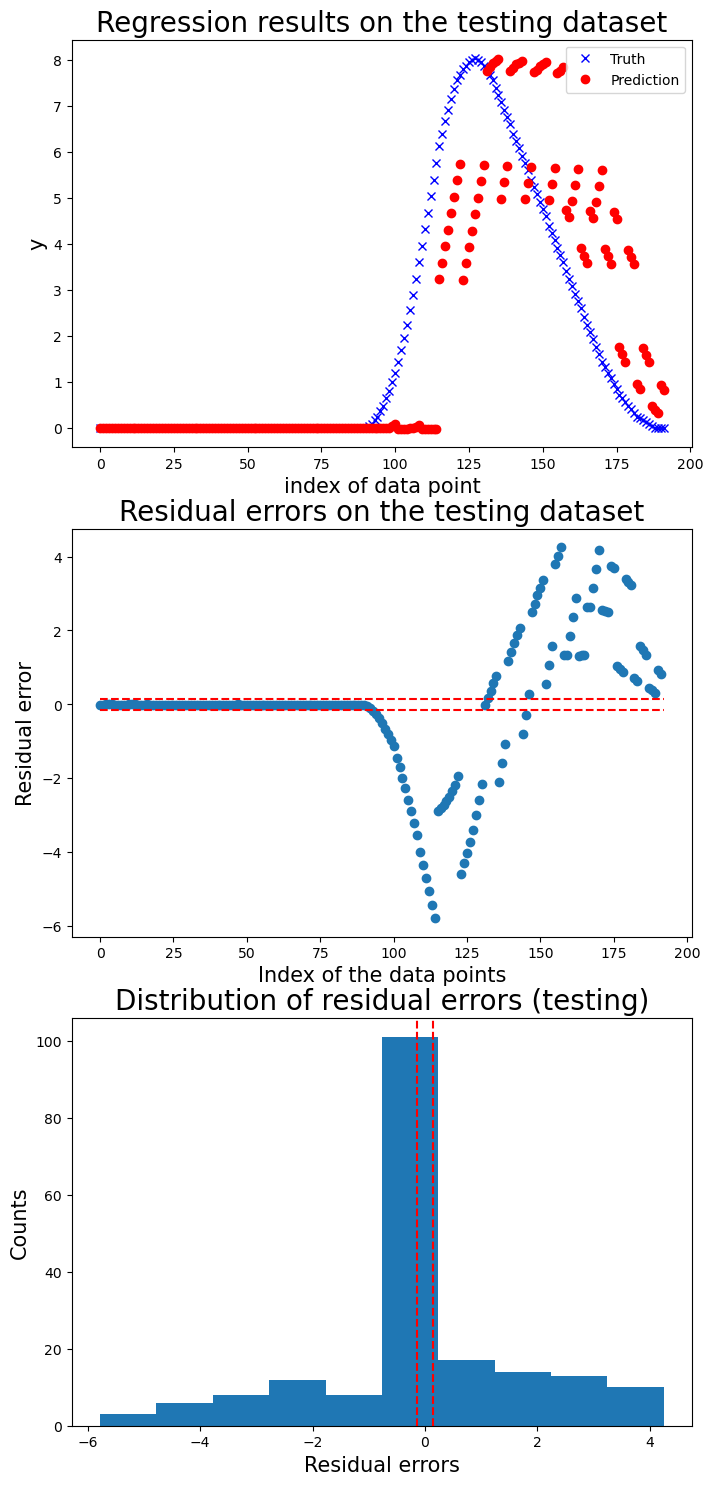

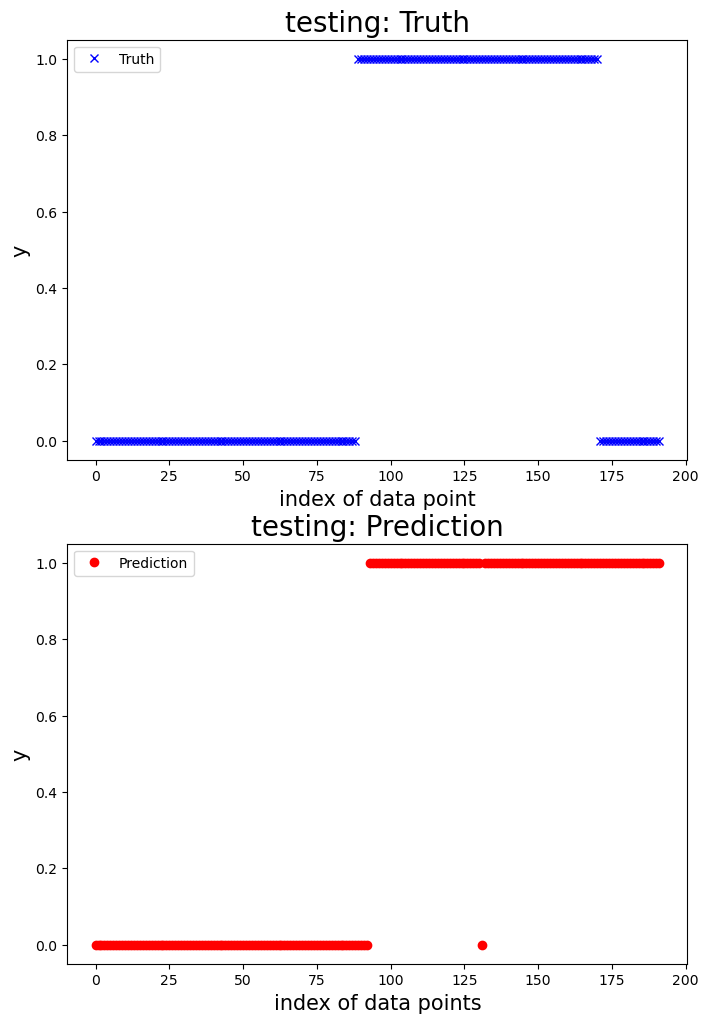

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



 New run:

testing performance, max error is: 2.5594385888478772
testing performance, mean root square error is: 0.7372224010329875
testing performance, residual error > 0.15: 20.92130518234165%

 New run:

testing performance, accuracy is: 0.9616122840690979
testing performance, precision is: 1.0
testing performance, recall: 0.8449612403100775
testing performance, F1: 0.9159663865546218




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


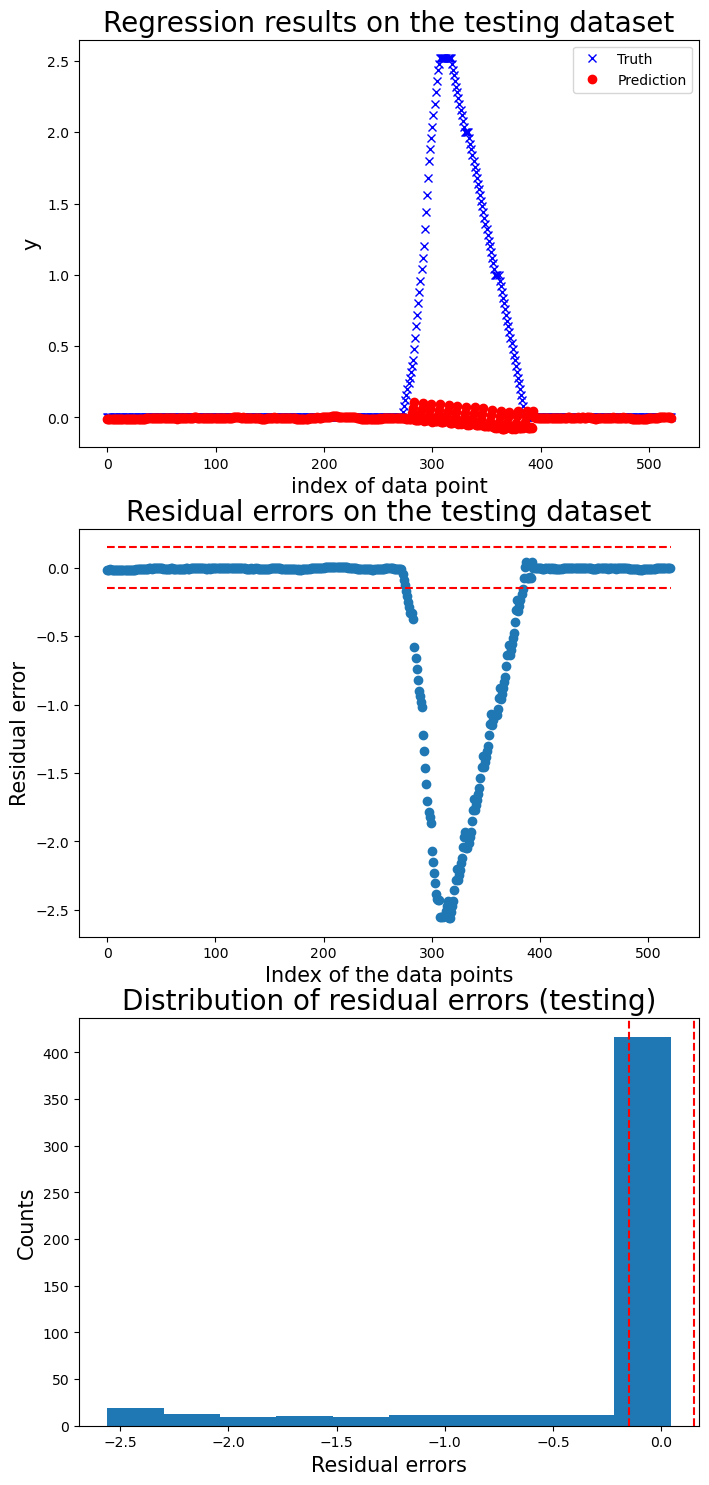

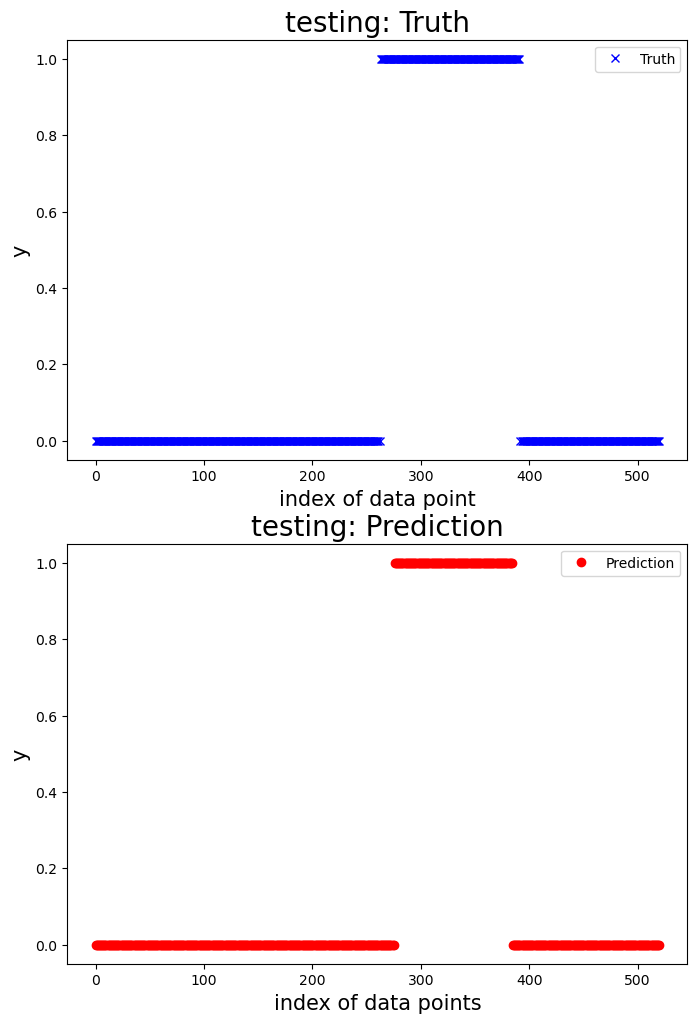

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]



 New run:

testing performance, max error is: 1.423433770039267
testing performance, mean root square error is: 0.22758347616350383
testing performance, residual error > 0.15: 8.45771144278607%

 New run:

testing performance, accuracy is: 0.9582089552238806
testing performance, precision is: 0.6235294117647059
testing performance, recall: 0.8412698412698413
testing performance, F1: 0.7162162162162162




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


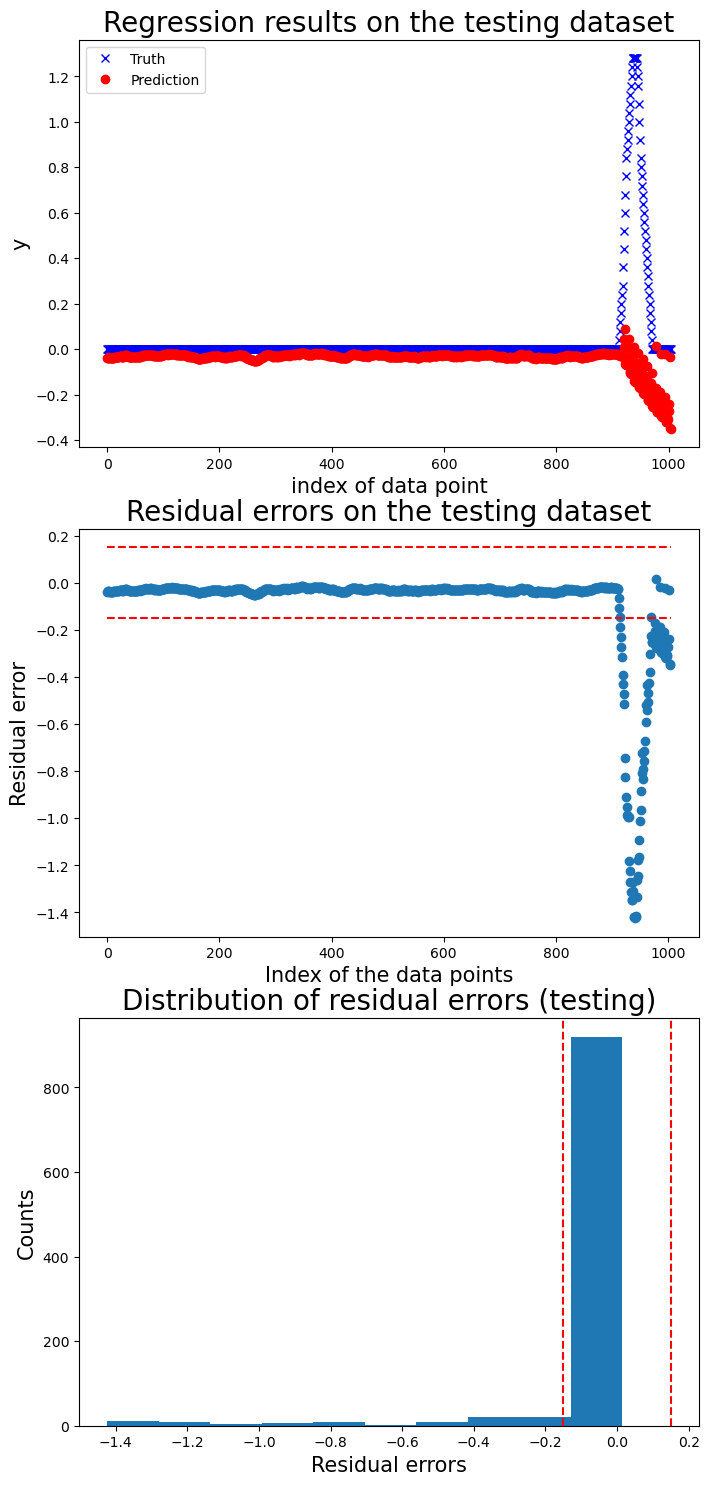

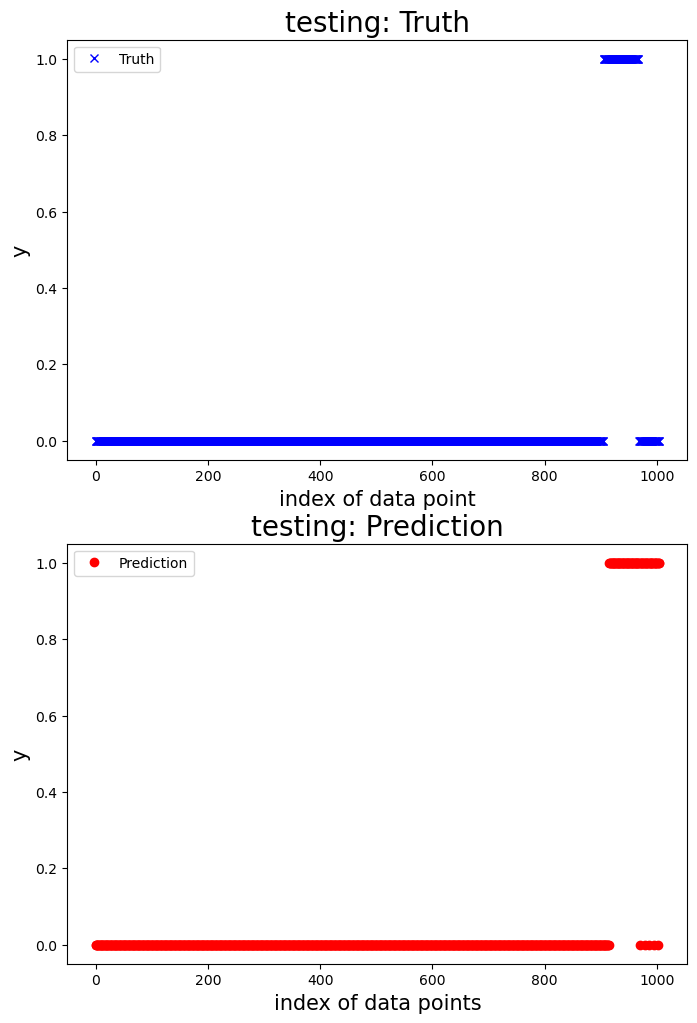

100%|██████████| 1/1 [00:01<00:00,  1.39s/it]



 New run:

testing performance, max error is: 3.84876374476011
testing performance, mean root square error is: 1.2099744336953495
testing performance, residual error > 0.6532390298908429: 58.828828828828826%

 New run:

testing performance, accuracy is: 0.5126126126126126
testing performance, precision is: 0.38773148148148145
testing performance, recall: 0.9654178674351584
testing performance, F1: 0.5532617671345995




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


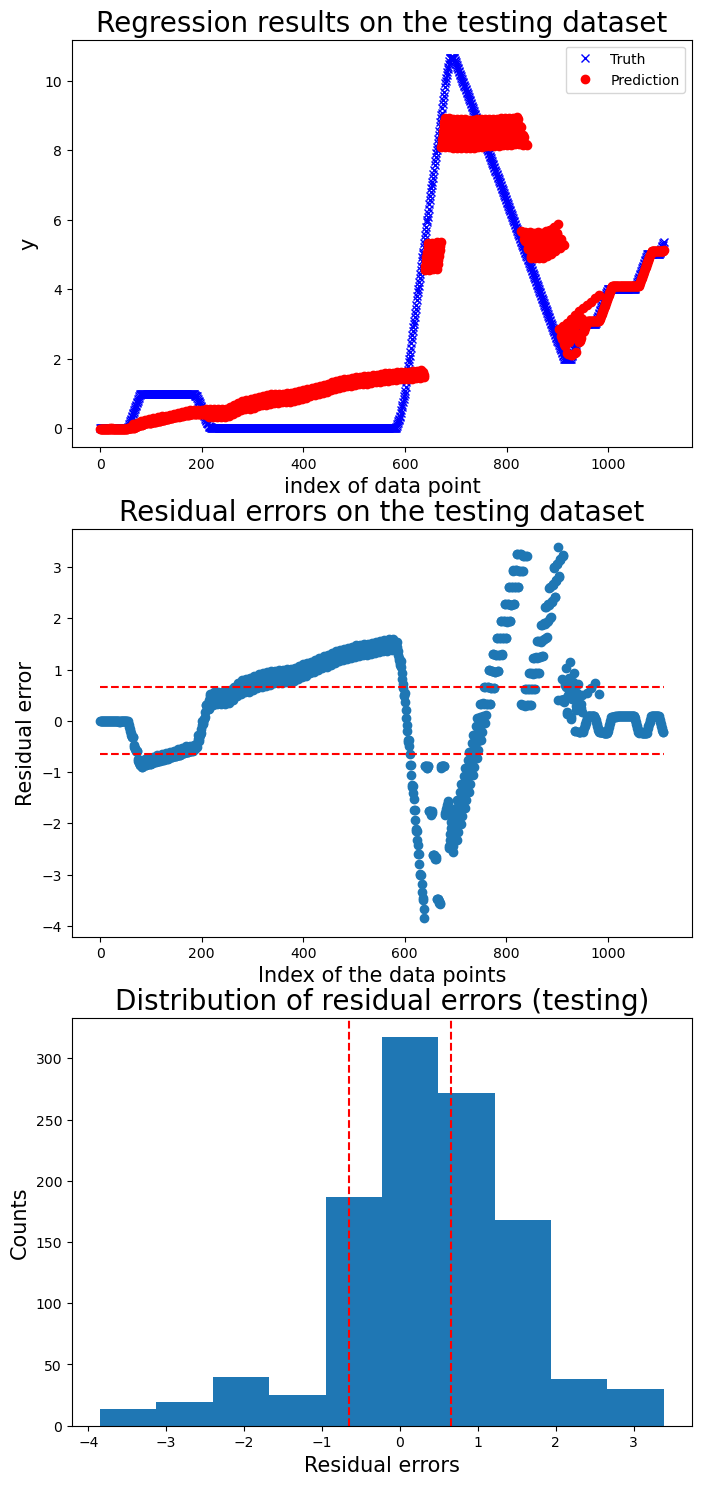

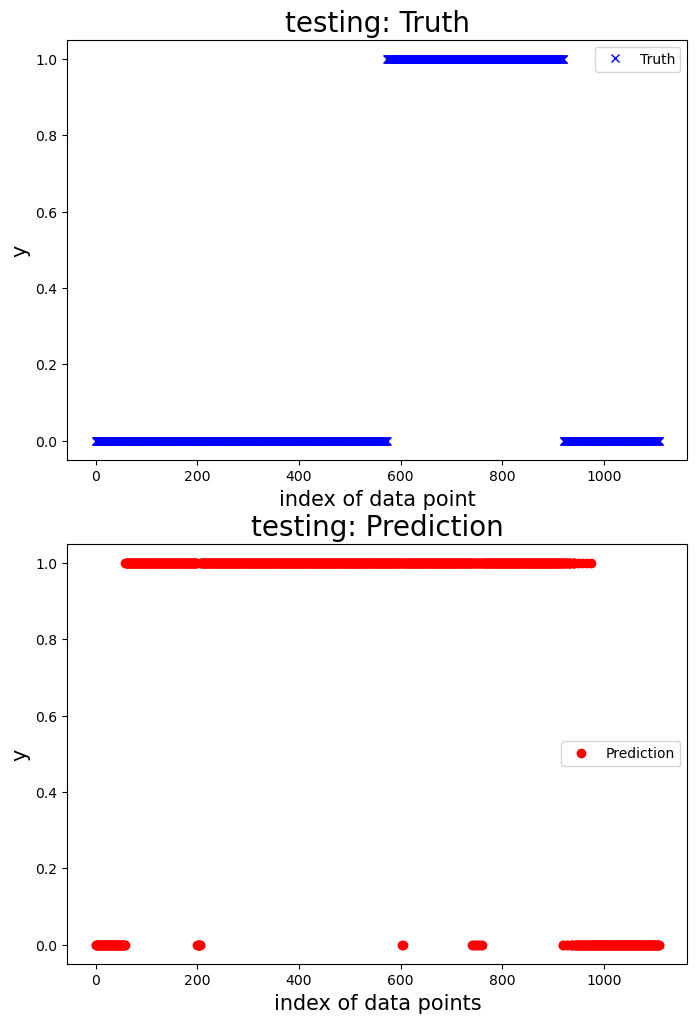

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]



 New run:

testing performance, max error is: 3.7704327612315245
testing performance, mean root square error is: 1.8126433206092059
testing performance, residual error > 0.8238310995311223: 59.285714285714285%

 New run:

testing performance, accuracy is: 0.8714285714285714
testing performance, precision is: 1.0
testing performance, recall: 0.85
testing performance, F1: 0.918918918918919




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


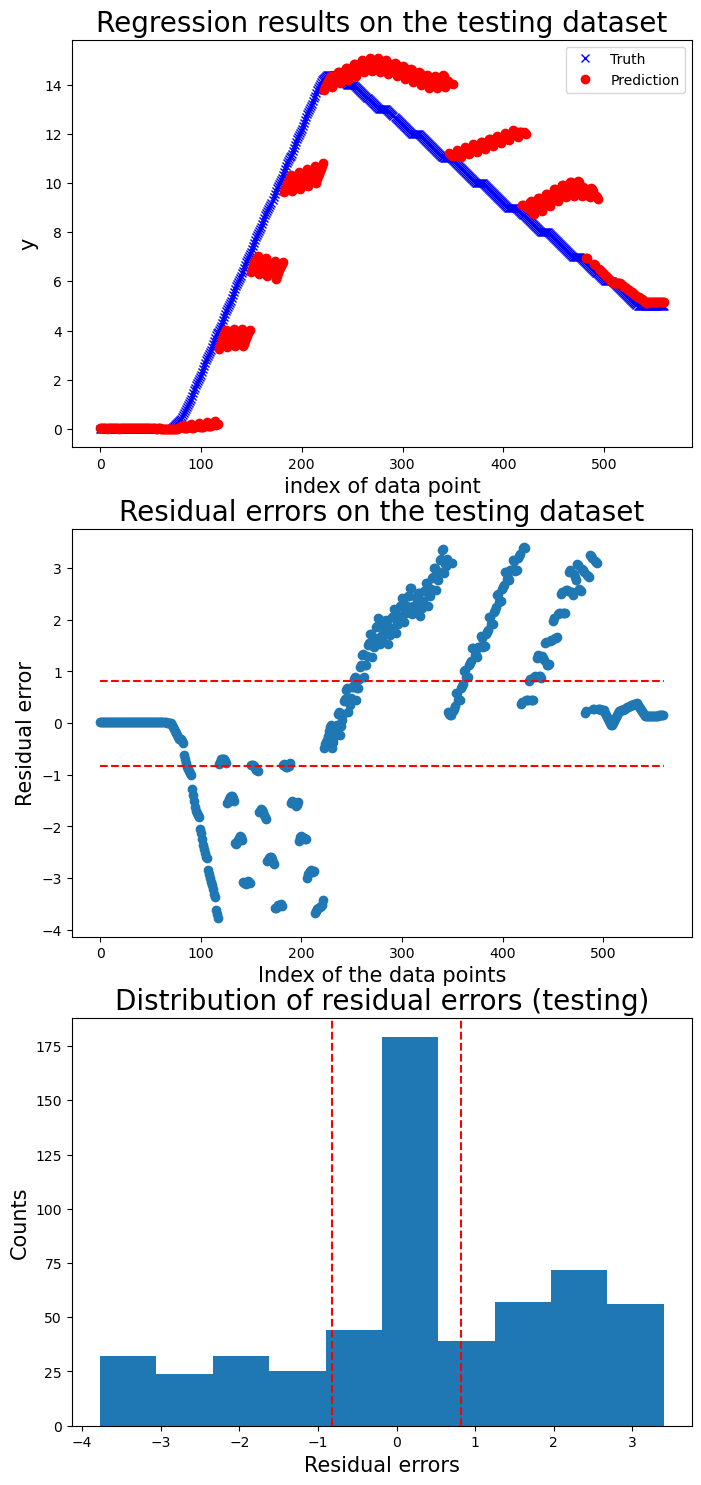

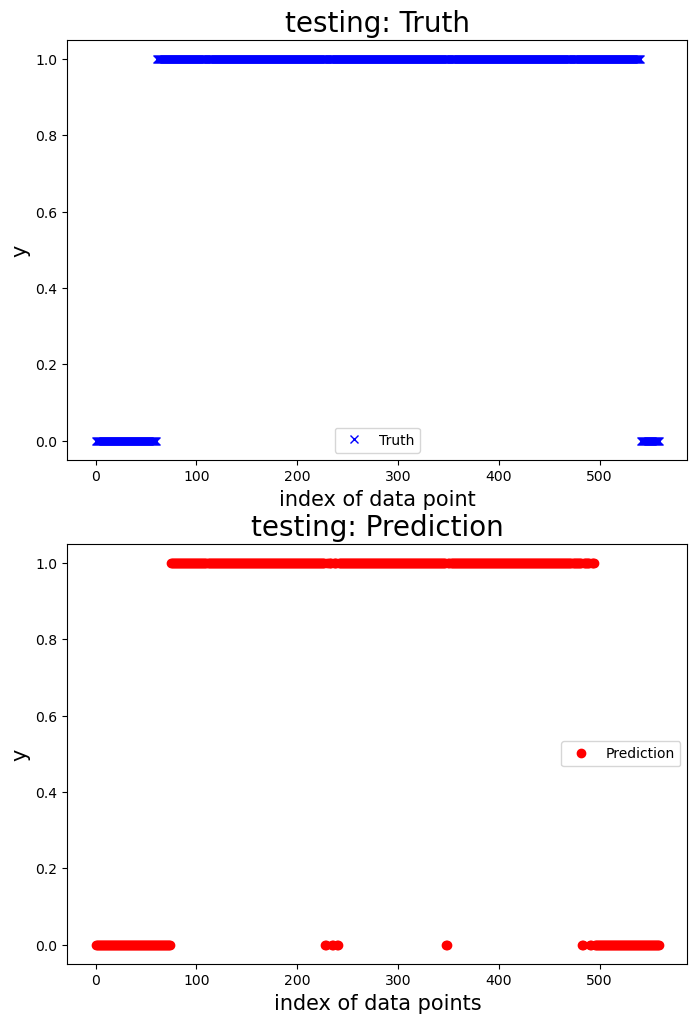

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]



 New run:

testing performance, max error is: 1.27271497924159
testing performance, mean root square error is: 0.31028516232203623
testing performance, residual error > 1.4834294538784505: 0.0%

 New run:

testing performance, accuracy is: 0.7127371273712737
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




c:\Users\gioca\GitHub\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


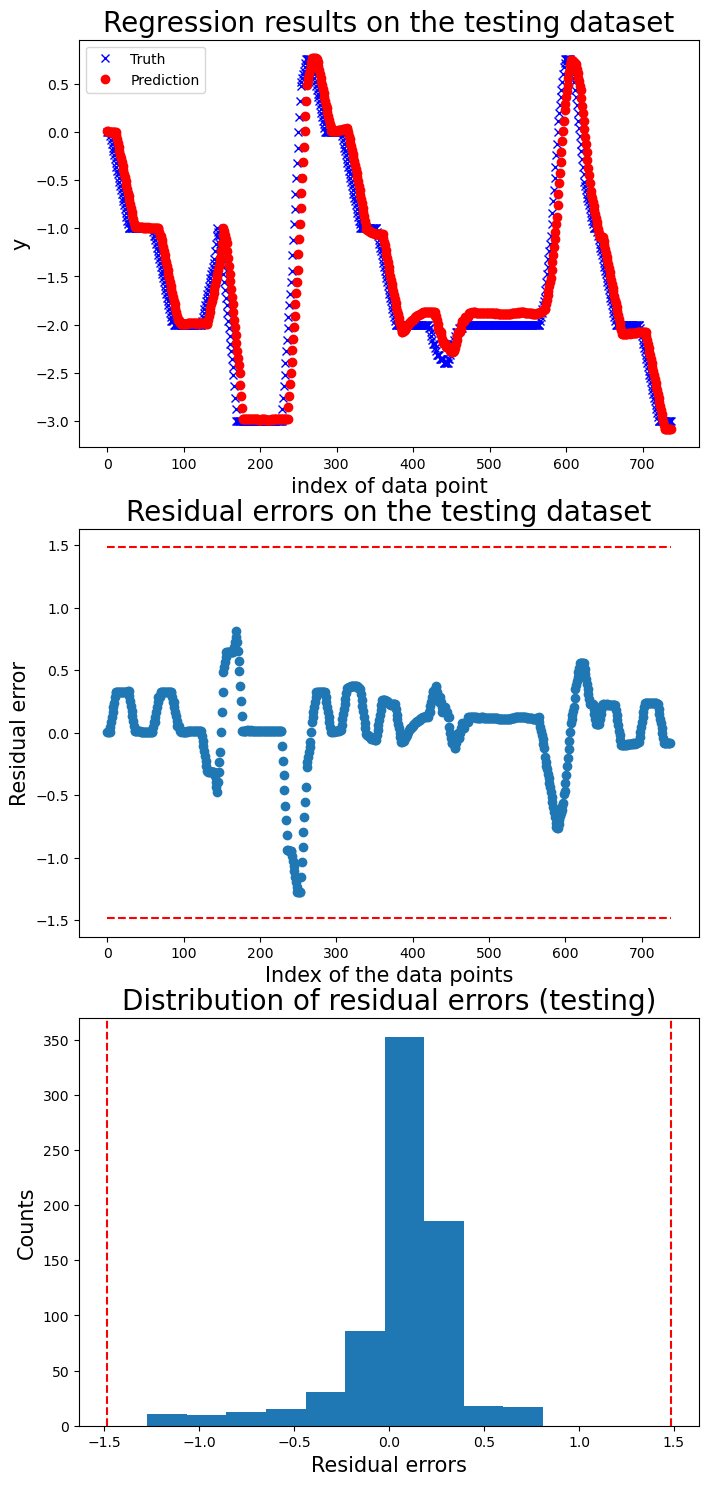

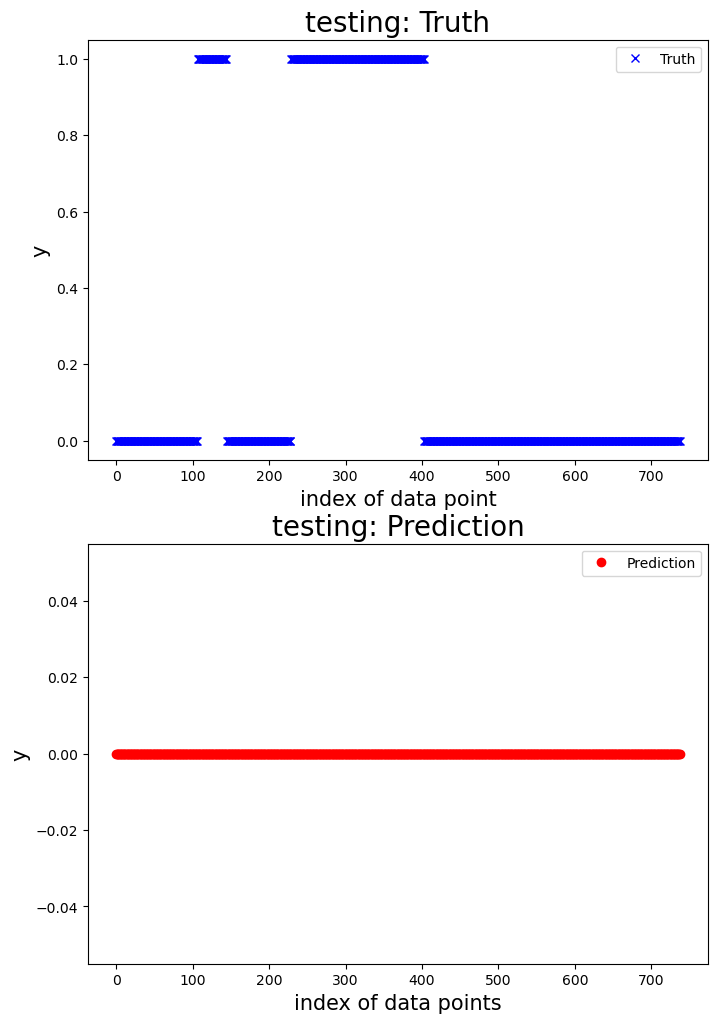

   Accuracy  Precision    Recall  F1 score
0  0.900801   0.000000  0.000000  0.000000
1  0.864583   0.785714  0.939024  0.855556
2  0.961612   1.000000  0.844961  0.915966
3  0.958209   0.623529  0.841270  0.716216
4  0.512613   0.387731  0.965418  0.553262
5  0.871429   1.000000  0.850000  0.918919
6  0.712737   0.000000  0.000000  0.000000


Mean performance metric and standard error:
Accuracy: 0.8260 +- 0.1613
Precision: 0.5424 +- 0.4276
Recall: 0.6344 +- 0.4361
F1 score: 0.5657 +- 0.4071




In [ ]:
# Your code here:

df_tr = df_data_sts_tr
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=selected_features_4, motor_idx=6, mdl_type='reg')

threshold = 0.15
window_size = 16
sample_step = 8
prediction_lead_time = 1
abnormal_limit = 3

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)
# Fit the model
mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

test_id = ['20240325_155003', '20240425_093699', '20240425_094425', '20240426_140055',
           '20240503_163963', '20240503_164675', '20240503_165189']

df_test = df_data_sts[df_data_sts['test_condition'].isin(test_id)]
detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# Test
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=selected_features_4, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=selected_features_4, motor_idx=6, mdl_type='reg')

# Predict the temperature 
detector_reg.threshold = 1
y_label_pred_tr, y_temp_pred_tr = detector_reg.predict(df_x_test=x_tr_org, y_response_test=y_temp_tr_org)
y_label_pred_tmp, y_temp_pred_tmp = detector_reg.predict(df_x_test=x_test_org, y_response_test=y_temp_test_org)

# Get the true values.
_, y_label_test = prepare_sliding_window(df_x=x_test_org, y=y_label_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='clf')
_, y_temp_test_seq = prepare_sliding_window(df_x=x_test_org, y=y_temp_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')


# show_reg_result(y_tr=y_temp_tr, y_test=y_temp_test_seq, y_pred_tr=y_temp_pred_tr, y_pred=y_temp_pred_tmp, threshold=detector_reg.threshold)
# show_clf_result(y_tr=np.zeros(len(y_label_pred_tr)), y_test=y_label_test, y_pred_tr=y_label_pred_tr, y_pred=y_label_pred_tmp)

n_fold = 7
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=selected_features_4,  motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=selected_features_4, motor_idx=6, mdl_type='reg')

motor_idx = 6
print(f'Model for motor {motor_idx}:')
# Run cross validation.
df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, n_fold=n_fold)
print(df_perf)
print('\n')
# Print the mean performance and standard error.
print('Mean performance metric and standard error:')
for name, metric, error in zip(df_perf.columns, df_perf.mean(), df_perf.std()):
    print(f'{name}: {metric:.4f} +- {error:.4f}') 
print('\n')

In [ ]:
# Task 2 Function: input = features, dataset training, 

def Task2 (ds_training, features, window_size, sample_step, )
df_tr = df_data_sts_tr
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=selected_features_4, motor_idx=6, mdl_type='reg')

threshold = 0.15
window_size = 16
sample_step = 8
prediction_lead_time = 1
abnormal_limit = 3

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)
# Fit the model
mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

test_id = ['20240325_155003', '20240425_093699', '20240425_094425', '20240426_140055',
           '20240503_163963', '20240503_164675', '20240503_165189']

df_test = df_data_sts[df_data_sts['test_condition'].isin(test_id)]
detector_reg = FaultDetectReg(reg_mdl=mdl, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# Test
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=selected_features_4, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=selected_features_4, motor_idx=6, mdl_type='reg')

# Predict the temperature 
detector_reg.threshold = 1
y_label_pred_tr, y_temp_pred_tr = detector_reg.predict(df_x_test=x_tr_org, y_response_test=y_temp_tr_org)
y_label_pred_tmp, y_temp_pred_tmp = detector_reg.predict(df_x_test=x_test_org, y_response_test=y_temp_test_org)

# Get the true values.
_, y_label_test = prepare_sliding_window(df_x=x_test_org, y=y_label_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='clf')
_, y_temp_test_seq = prepare_sliding_window(df_x=x_test_org, y=y_temp_test_org, sequence_name_list=test_id, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')


# show_reg_result(y_tr=y_temp_tr, y_test=y_temp_test_seq, y_pred_tr=y_temp_pred_tr, y_pred=y_temp_pred_tmp, threshold=detector_reg.threshold)
# show_clf_result(y_tr=np.zeros(len(y_label_pred_tr)), y_test=y_label_test, y_pred_tr=y_label_pred_tr, y_pred=y_label_pred_tmp)

n_fold = 7
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=selected_features_4,  motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=selected_features_4, motor_idx=6, mdl_type='reg')

motor_idx = 6
print(f'Model for motor {motor_idx}:')
# Run cross validation.
df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, n_fold=n_fold)
print(df_perf)
print('\n')
# Print the mean performance and standard error.
print('Mean performance metric and standard error:')
for name, metric, error in zip(df_perf.columns, df_perf.mean(), df_perf.std()):
    print(f'{name}: {metric:.4f} +- {error:.4f}') 
print('\n')

## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got (including key parameters like threshold, window_size, sample_step, prediction_lead_time, etc), its performance, and how could you further improve it.

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
